# 1. Import required packages

In [1]:
%%capture
!pip install timm
!pip install randaugment

In [2]:
import os
import PIL
import time
import timm
import math
import copy
import torch
import torchvision
import itertools
import numpy as np
%matplotlib inline
import torch.nn as nn
from PIL import Image
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from timm.models.layers.activations import *
from collections import OrderedDict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from randaugment import RandAugment, ImageNetPolicy, Cutout
from tqdm import tqdm

# 2. Dataloader

In [3]:
# Hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 50

In [4]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        Cutout(size=16),
        RandAugment(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print('Dataset size: ', dataset_sizes)
print('Class names: ', class_names)

Dataset size:  {'train': 17813, 'val': 2227, 'test': 2229}
Class names:  ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# 3. ResNet50

In [6]:
model = timm.create_model('resnet50', pretrained=True)
model.fc

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


Linear(in_features=2048, out_features=1000, bias=True)

In [7]:
from collections import OrderedDict

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),
    ('relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(1024, 256)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(256, 5))
]))

model.fc = fc
model = model.to(device)

### Count model params
for params in model.parameters():
    params.requires_grad = True

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ResNet50 parameters: ", count_params(model))

ResNet50 parameters:  25869893


# 4. Training model

In [8]:
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS , path='model.pth'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.

    train_log = {'loss': [],
                 'acc': []}
    val_log = {'loss': [],
              'acc': []}
    
    for epoch in range(num_epochs):
        
        print('-'*5, f'Epoch {epoch+1}/{num_epochs}', '-'*5)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i, (inputs, labels) in tqdm(enumerate(data_loader[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data).item()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct / dataset_sizes[phase]
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                scheduler.step()
                train_log['loss'].append(epoch_loss)
                train_log['acc'].append(epoch_acc)
            else:
                val_log['loss'].append(epoch_loss)
                val_log['acc'].append(epoch_acc)
            
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
                
    time_elapsed = time.time()-since
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model, train_log, val_log

In [10]:
model, train_log, val_log = train_model(model, criterion, optimizer, scheduler)

----- Epoch 1/50 -----


1114it [05:07,  3.63it/s]

train loss: 1.2547 acc: 0.5425



140it [00:23,  6.03it/s]


val loss: 1.0673 acc: 0.6542
New acc: 0.6542, previous acc: 0.0000
----- Epoch 2/50 -----


1114it [04:41,  3.96it/s]

train loss: 1.1326 acc: 0.6064



140it [00:19,  7.16it/s]


val loss: 0.9683 acc: 0.7009
New acc: 0.7009, previous acc: 0.6542
----- Epoch 3/50 -----


1114it [04:44,  3.91it/s]

train loss: 1.0580 acc: 0.6470



140it [00:19,  7.11it/s]


val loss: 0.8357 acc: 0.7777
New acc: 0.7777, previous acc: 0.7009
----- Epoch 4/50 -----


1114it [04:45,  3.90it/s]

train loss: 0.9933 acc: 0.6824



140it [00:21,  6.59it/s]


val loss: 0.7929 acc: 0.8047
New acc: 0.8047, previous acc: 0.7777
----- Epoch 5/50 -----


1114it [04:46,  3.88it/s]

train loss: 0.9510 acc: 0.7071



140it [00:20,  6.90it/s]

val loss: 0.8083 acc: 0.7845
----- Epoch 6/50 -----



1114it [04:49,  3.85it/s]

train loss: 0.9045 acc: 0.7336



140it [00:19,  7.16it/s]


val loss: 0.7116 acc: 0.8388
New acc: 0.8388, previous acc: 0.8047
----- Epoch 7/50 -----


1114it [04:49,  3.85it/s]

train loss: 0.8836 acc: 0.7441



140it [00:20,  6.68it/s]

val loss: 0.7689 acc: 0.8163
----- Epoch 8/50 -----



1114it [04:52,  3.81it/s]

train loss: 0.8581 acc: 0.7568



140it [00:21,  6.53it/s]

val loss: 0.7586 acc: 0.8348
----- Epoch 9/50 -----



1114it [04:47,  3.88it/s]

train loss: 0.8406 acc: 0.7699



140it [00:19,  7.07it/s]


val loss: 0.6568 acc: 0.8693
New acc: 0.8693, previous acc: 0.8388
----- Epoch 10/50 -----


1114it [04:45,  3.91it/s]

train loss: 0.8267 acc: 0.7734



140it [00:21,  6.44it/s]

val loss: 0.6581 acc: 0.8675
----- Epoch 11/50 -----



1114it [04:44,  3.92it/s]

train loss: 0.7976 acc: 0.7882



140it [00:19,  7.15it/s]

val loss: 0.6713 acc: 0.8608
----- Epoch 12/50 -----



1114it [04:46,  3.89it/s]

train loss: 0.7833 acc: 0.7947



140it [00:18,  7.39it/s]

val loss: 0.6646 acc: 0.8644
----- Epoch 13/50 -----



1114it [04:45,  3.90it/s]

train loss: 0.7769 acc: 0.7970



140it [00:23,  6.04it/s]

val loss: 0.6740 acc: 0.8630
----- Epoch 14/50 -----



1114it [04:46,  3.89it/s]

train loss: 0.7731 acc: 0.8036



140it [00:19,  7.09it/s]

val loss: 0.6675 acc: 0.8604
----- Epoch 15/50 -----



1114it [04:48,  3.86it/s]

train loss: 0.7648 acc: 0.8068



140it [00:19,  7.34it/s]


val loss: 0.6363 acc: 0.8783
New acc: 0.8783, previous acc: 0.8693
----- Epoch 16/50 -----


1114it [04:49,  3.85it/s]

train loss: 0.7564 acc: 0.8106



140it [00:19,  7.04it/s]


val loss: 0.6435 acc: 0.8850
New acc: 0.8850, previous acc: 0.8783
----- Epoch 17/50 -----


1114it [04:49,  3.85it/s]

train loss: 0.7560 acc: 0.8099



140it [00:24,  5.81it/s]


val loss: 0.6117 acc: 0.8949
New acc: 0.8949, previous acc: 0.8850
----- Epoch 18/50 -----


1114it [04:51,  3.82it/s]

train loss: 0.7531 acc: 0.8104



140it [00:21,  6.52it/s]


val loss: 0.6012 acc: 0.9003
New acc: 0.9003, previous acc: 0.8949
----- Epoch 19/50 -----


1114it [04:41,  3.95it/s]

train loss: 0.7484 acc: 0.8146



140it [00:19,  7.04it/s]

val loss: 0.6147 acc: 0.8945
----- Epoch 20/50 -----



1114it [04:42,  3.95it/s]

train loss: 0.7442 acc: 0.8178



140it [00:19,  7.19it/s]


val loss: 0.5973 acc: 0.9070
New acc: 0.9070, previous acc: 0.9003
----- Epoch 21/50 -----


1114it [04:46,  3.88it/s]

train loss: 0.7268 acc: 0.8267



140it [00:19,  7.19it/s]

val loss: 0.6061 acc: 0.8954
----- Epoch 22/50 -----



1114it [04:44,  3.91it/s]

train loss: 0.7221 acc: 0.8281



140it [00:25,  5.51it/s]


val loss: 0.5763 acc: 0.9138
New acc: 0.9138, previous acc: 0.9070
----- Epoch 23/50 -----


1114it [04:46,  3.88it/s]

train loss: 0.7203 acc: 0.8314



140it [00:19,  7.25it/s]

val loss: 0.5791 acc: 0.9106
----- Epoch 24/50 -----



1114it [04:48,  3.87it/s]

train loss: 0.7115 acc: 0.8360



140it [00:19,  7.10it/s]

val loss: 0.5968 acc: 0.9030
----- Epoch 25/50 -----



1114it [04:49,  3.85it/s]

train loss: 0.7126 acc: 0.8322



140it [00:19,  7.01it/s]

val loss: 0.5865 acc: 0.9012
----- Epoch 26/50 -----



1114it [04:48,  3.86it/s]

train loss: 0.7043 acc: 0.8377



140it [00:19,  7.36it/s]

val loss: 0.5903 acc: 0.9120
----- Epoch 27/50 -----



1114it [04:45,  3.91it/s]

train loss: 0.7032 acc: 0.8385



140it [00:25,  5.44it/s]

val loss: 0.6092 acc: 0.8958
----- Epoch 28/50 -----



1114it [04:46,  3.88it/s]

train loss: 0.7041 acc: 0.8379



140it [00:20,  6.88it/s]

val loss: 0.5945 acc: 0.9044
----- Epoch 29/50 -----



1114it [04:46,  3.89it/s]

train loss: 0.7062 acc: 0.8379



140it [00:18,  7.39it/s]

val loss: 0.5738 acc: 0.9133
----- Epoch 30/50 -----



1114it [04:46,  3.89it/s]

train loss: 0.6991 acc: 0.8403



140it [00:19,  7.21it/s]

val loss: 0.5899 acc: 0.9066
----- Epoch 31/50 -----



1114it [04:56,  3.76it/s]

train loss: 0.6912 acc: 0.8444



140it [00:19,  7.17it/s]


val loss: 0.5745 acc: 0.9160
New acc: 0.9160, previous acc: 0.9138
----- Epoch 32/50 -----


1114it [04:48,  3.86it/s]

train loss: 0.6908 acc: 0.8447



140it [00:19,  7.17it/s]

val loss: 0.5783 acc: 0.9133
----- Epoch 33/50 -----



1114it [04:49,  3.85it/s]

train loss: 0.6828 acc: 0.8522



140it [00:19,  7.19it/s]


val loss: 0.5606 acc: 0.9250
New acc: 0.9250, previous acc: 0.9160
----- Epoch 34/50 -----


1114it [04:52,  3.80it/s]

train loss: 0.6926 acc: 0.8441



140it [00:19,  7.03it/s]

val loss: 0.5624 acc: 0.9237
----- Epoch 35/50 -----



1114it [04:53,  3.79it/s]

train loss: 0.6878 acc: 0.8469



140it [00:24,  5.63it/s]

val loss: 0.5640 acc: 0.9210
----- Epoch 36/50 -----



1114it [04:49,  3.85it/s]

train loss: 0.6848 acc: 0.8508



140it [00:25,  5.44it/s]

val loss: 0.5588 acc: 0.9246
----- Epoch 37/50 -----



1114it [04:44,  3.91it/s]

train loss: 0.6865 acc: 0.8485



140it [00:20,  6.93it/s]

val loss: 0.5638 acc: 0.9192
----- Epoch 38/50 -----



1114it [04:43,  3.93it/s]

train loss: 0.6838 acc: 0.8495



140it [00:19,  7.28it/s]

val loss: 0.5820 acc: 0.9093
----- Epoch 39/50 -----



1114it [04:43,  3.93it/s]

train loss: 0.6820 acc: 0.8511



140it [00:19,  7.14it/s]

val loss: 0.5683 acc: 0.9174
----- Epoch 40/50 -----



1114it [04:46,  3.89it/s]

train loss: 0.6858 acc: 0.8480



140it [00:27,  5.09it/s]

val loss: 0.5566 acc: 0.9223
----- Epoch 41/50 -----



1114it [04:50,  3.83it/s]

train loss: 0.6798 acc: 0.8524



140it [00:19,  7.15it/s]


val loss: 0.5535 acc: 0.9282
New acc: 0.9282, previous acc: 0.9250
----- Epoch 42/50 -----


1114it [04:46,  3.88it/s]

train loss: 0.6763 acc: 0.8522



140it [00:19,  7.31it/s]

val loss: 0.5581 acc: 0.9259
----- Epoch 43/50 -----



1114it [04:47,  3.88it/s]

train loss: 0.6812 acc: 0.8530



140it [00:19,  7.22it/s]

val loss: 0.5568 acc: 0.9237
----- Epoch 44/50 -----



1114it [04:49,  3.85it/s]

train loss: 0.6747 acc: 0.8535



140it [00:19,  7.10it/s]

val loss: 0.5574 acc: 0.9255
----- Epoch 45/50 -----



1114it [04:45,  3.90it/s]

train loss: 0.6792 acc: 0.8476



140it [00:19,  7.30it/s]

val loss: 0.5660 acc: 0.9205
----- Epoch 46/50 -----



1114it [04:47,  3.87it/s]

train loss: 0.6793 acc: 0.8526



140it [00:19,  7.12it/s]

val loss: 0.5560 acc: 0.9250
----- Epoch 47/50 -----



1114it [04:47,  3.87it/s]

train loss: 0.6699 acc: 0.8564



140it [00:19,  7.08it/s]

val loss: 0.5722 acc: 0.9178
----- Epoch 48/50 -----



1114it [04:47,  3.87it/s]


train loss: 0.6713 acc: 0.8538


140it [00:19,  7.29it/s]

val loss: 0.5689 acc: 0.9205
----- Epoch 49/50 -----



1114it [04:49,  3.84it/s]

train loss: 0.6654 acc: 0.8598



140it [00:28,  4.84it/s]

val loss: 0.5491 acc: 0.9282
----- Epoch 50/50 -----



1114it [04:50,  3.84it/s]

train loss: 0.6755 acc: 0.8537



140it [00:20,  6.88it/s]

val loss: 0.5594 acc: 0.9259
Training complete in: 257m 27s
Best val acc: 0.9282 Best val loss: 0.5535


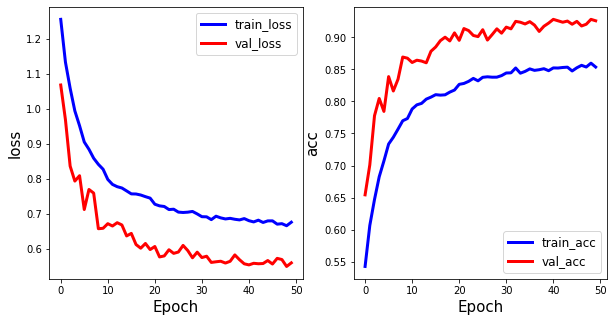

In [11]:
def plot_model_history(train_log, val_log, num_epochs):
    n = len(train_log)
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 5))
    plt.title("Training progress", fontsize=15)
    for i, k in enumerate(train_log.keys()):       
        plt.subplot(n//2, 2, i+1)
        plt.plot(x, train_log[k], label=f'train_{k}', lw=3, c="b")
        plt.plot(x, val_log[k], label=f'val_{k}', lw=3, c="r")
        plt.legend(fontsize=12)
        plt.xlabel("Epoch", fontsize=15)
        plt.ylabel(f"{k}", fontsize=15)
    plt.show()
    
plot_model_history(train_log, val_log, NUM_EPOCHS)

# 5. Prediction on Test set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# model = timm.create_model('resnet50', pretrained=True)
# fc = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(2048, 1024)),
#     ('relu1', nn.ReLU(inplace=True)),
#     ('fc2', nn.Linear(1024, 256)),
#     ('relu2', nn.ReLU(inplace=True)),
#     ('fc3', nn.Linear(256, 5))
# ]))

# model.fc = fc
# model = model.to(device)

model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

Testing complete in 0m 27s
              precision    recall  f1-score   support

           0    0.96530   0.84530   0.90133       362
           1    0.90344   0.91694   0.91014       602
           2    0.91089   0.95472   0.93229      1060
           3    0.98387   0.90370   0.94208       135
           4    0.90909   0.85714   0.88235        70

    accuracy                        0.92059      2229
   macro avg    0.93452   0.89556   0.91364      2229
weighted avg    0.92208   0.92059   0.92030      2229



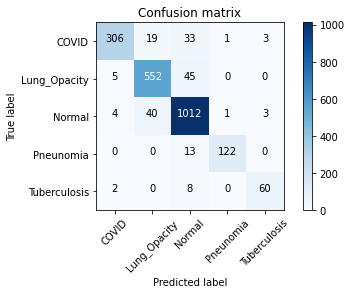

In [14]:
since = time.time()
model.eval()
y_test = []
y_pred = []
y_pred_proba = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    y_pred_proba.append(outputs.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)

In [15]:
def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

y_pred_proba = np.array([list(softmax(i)) for i in y_pred_proba])

ROC curve (area = 0.9906)


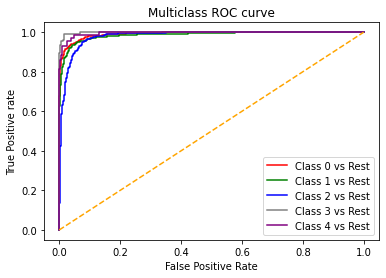

In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print('ROC curve (area = %0.4f)' % roc_auc)
fpr = {}
tpr = {}
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], color='gray', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], color='purple', label='Class 4 vs Rest')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 